# Face Mask Detection

## Packages

In [1]:
from time import time
from imutils import paths
import cv2, random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import neighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

## Preprocessing

In [2]:
#### BASIC PARAMETERS ####

# IMAGE SIZE
img_height = 224
img_width = 224

In [4]:
# LOADING IMAGES
print("[INFO] LOADING IMAGES...")
t0 = time()
data_dir = "../dataset"
PATH = list(paths.list_images(data_dir))

data = []
label = []
for img_path in PATH:
    image = cv2.imread(img_path, 0)
    image = cv2.resize(image, (img_width, img_height))
    
    data.append(image.flatten()/255.0)
    label.append(img_path.split('\\')[-2])
    
    if len(label) % 500 == 0:
        print("[INFO]", len(label), "images have been loaded.") 

data = np.array(data, dtype="float32")
label = np.array(label)
print("[INFO] LOADED", len(label), "IMAGES in %0.3fs" % (time() - t0))

[INFO] LOADING IMAGES...
[INFO] 500 images have been loaded.
[INFO] 1000 images have been loaded.
[INFO] 1500 images have been loaded.
[INFO] 2000 images have been loaded.
[INFO] 2500 images have been loaded.
[INFO] 3000 images have been loaded.
[INFO] LOADED 3400 IMAGES in 3.488s


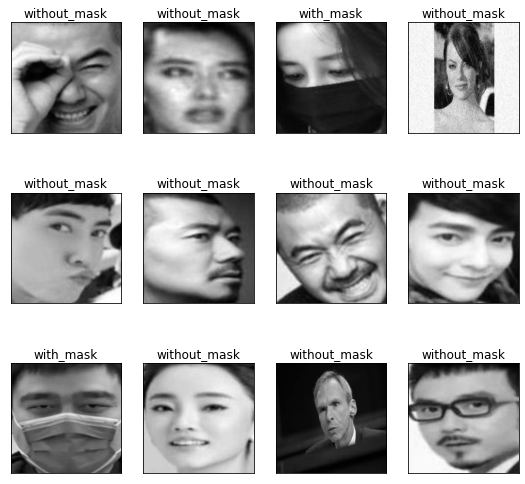

In [10]:
# PREVIEW DATA
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# PREVIEW DATA
img_index = random.sample(range(label.shape[0]), k=12)
images = [np.reshape(img, (img_height, img_width)) for img in data[img_index]]
titles = label[img_index]
plot_gallery(images, titles, img_height, img_width)

In [11]:
# SPLIT DATA INTO TRAINING AND TESTING SET
X_train, X_test, y_train, y_test = train_test_split(
    data, label,
    test_size=0.20,
    stratify=label,
    random_state=42
)

## DIMENSIONALITY REDUCTION METHOD

In [12]:
# COMPUTE A PCA (EIGENFACES)
n_components = 15
print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))
eigenfaces = pca.components_.reshape((n_components, img_height, img_width))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
data_pca = pca.transform(data)
print("done in %0.3fs" % (time() - t0))

Extracting the top 15 eigenfaces from 2720 faces
done in 1.815s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.765s


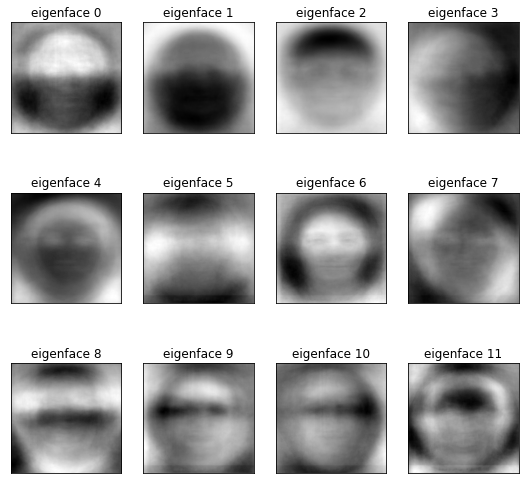

In [13]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, img_height, img_width)

## MACHINE LEARNING CLASSIFICATION ALGORITHM

### Support Vector Machines

In [124]:
# TRAIN A SVM CLASSIFICATION MODEL
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
}
SVM = GridSearchCV(
    SVC(kernel='rbf',
        class_weight='balanced',
        probability = True,
        verbose = True
        ),
    param_grid,
    verbose=10,
    n_jobs=-1
)
SVM = SVM.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(SVM.best_estimator_)

Fitting the classifier to the training set
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.2min finished


[LibSVM]done in 241.260s
Best estimator found by grid search:
SVC(C=100000.0, class_weight='balanced', gamma=0.001, probability=True,
    verbose=True)


In [14]:
SVM = SVC(C=100000.0,
          class_weight='balanced',
          gamma=0.001,
          probability=True,
          verbose=True
)
SVM = SVM.fit(X_train_pca, y_train)

[LibSVM]

In [15]:
# EVALUATE CLASSIFIER PERFORMANCE
def EVALUATE(clf, clf_name):
    print("[",clf_name,"]")
    print("classification report on the test set")
    t0 = time()
    y_pred = clf.predict(X_test_pca)
    print("done in %0.3fs" % (time() - t0))
    print(classification_report(y_test, y_pred))
# EVALUATE CLASSIFIER PERFORMANCE(FULL VERSION)
def EVALUATE_FULL(clf, clf_name):
    print("[",clf_name,"]")
    print("classification report on the test set")
    t0 = time()
    y_pred = clf.predict(X_test)
    print("done in %0.3fs" % (time() - t0))
    print(classification_report(y_test, y_pred))

In [16]:
SVM = SVC(C=100000.0,
          class_weight='balanced',
          gamma=0.001,
          probability=True,
          verbose=True
        )
SVM = SVM.fit(X_train_pca, y_train)
EVALUATE(SVM, "SVM")

[LibSVM][ SVM ]
classification report on the test set
done in 0.012s
              precision    recall  f1-score   support

   with_mask       0.87      0.85      0.86       294
without_mask       0.89      0.90      0.89       386

    accuracy                           0.88       680
   macro avg       0.88      0.88      0.88       680
weighted avg       0.88      0.88      0.88       680



### Decision Tree

In [17]:
DecisionTree = DecisionTreeClassifier(random_state=42)
DecisionTree.fit(X_train_pca, y_train)
EVALUATE(DecisionTree, "Decision Tree")

[ Decision Tree ]
classification report on the test set
done in 0.001s
              precision    recall  f1-score   support

   with_mask       0.70      0.70      0.70       294
without_mask       0.77      0.77      0.77       386

    accuracy                           0.74       680
   macro avg       0.74      0.74      0.74       680
weighted avg       0.74      0.74      0.74       680



### Logistic Regression

In [18]:
Logistic = LogisticRegression()
Logistic.fit(X_train_pca, y_train)
EVALUATE(Logistic, "Logistic Regression")

[ Logistic Regression ]
classification report on the test set
done in 0.000s
              precision    recall  f1-score   support

   with_mask       0.70      0.56      0.62       294
without_mask       0.71      0.81      0.76       386

    accuracy                           0.71       680
   macro avg       0.70      0.69      0.69       680
weighted avg       0.70      0.71      0.70       680



### Stochastic Gradient Descent

In [19]:
SGD = SGDClassifier(loss="hinge", penalty="l2", n_jobs=-1)
SGD.fit(X_train, y_train)
EVALUATE_FULL(SGD, "Stochastic Gradient Descent")

[ Stochastic Gradient Descent ]
classification report on the test set
done in 0.124s
              precision    recall  f1-score   support

   with_mask       0.74      0.70      0.72       294
without_mask       0.78      0.81      0.80       386

    accuracy                           0.76       680
   macro avg       0.76      0.76      0.76       680
weighted avg       0.76      0.76      0.76       680



### Nearest Neighbors

In [20]:
n_neighbors = 12
weights = 'distance'
nbrs = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
# nbrs.fit(X_train_pca, y_train)
# EVALUATE(nbrs, "Nearest Neighbors")
nbrs.fit(X_train_pca, y_train)
EVALUATE(nbrs, "Nearest Neighbors")

[ Nearest Neighbors ]
classification report on the test set
done in 0.048s
              precision    recall  f1-score   support

   with_mask       0.91      0.72      0.81       294
without_mask       0.82      0.95      0.88       386

    accuracy                           0.85       680
   macro avg       0.87      0.84      0.84       680
weighted avg       0.86      0.85      0.85       680



### Gaussian Naive Bayes

In [21]:
gnb = GaussianNB()
gnb.fit(X_train_pca, y_train)
EVALUATE(gnb, "Gaussian Naive Bayes")

[ Gaussian Naive Bayes ]
classification report on the test set
done in 0.001s
              precision    recall  f1-score   support

   with_mask       0.74      0.63      0.68       294
without_mask       0.75      0.83      0.79       386

    accuracy                           0.74       680
   macro avg       0.74      0.73      0.73       680
weighted avg       0.74      0.74      0.74       680



### Random Forest

In [22]:
RandomForest = RandomForestClassifier()
RandomForest.fit(X_train_pca, y_train)
EVALUATE(RandomForest, "Random Forest")


[ Random Forest ]
classification report on the test set
done in 0.014s
              precision    recall  f1-score   support

   with_mask       0.88      0.79      0.83       294
without_mask       0.85      0.91      0.88       386

    accuracy                           0.86       680
   macro avg       0.86      0.85      0.85       680
weighted avg       0.86      0.86      0.86       680



 ### AdaBoost

In [23]:
AdaBoost = AdaBoostClassifier()
AdaBoost.fit(X_train_pca, y_train)
EVALUATE(AdaBoost, "AdaBoost")

[ AdaBoost ]
classification report on the test set
done in 0.008s
              precision    recall  f1-score   support

   with_mask       0.77      0.67      0.71       294
without_mask       0.77      0.84      0.80       386

    accuracy                           0.77       680
   macro avg       0.77      0.76      0.76       680
weighted avg       0.77      0.77      0.77       680



### Gradient Boosting

In [24]:
GradientBoosting = GradientBoostingClassifier()
GradientBoosting.fit(X_train_pca, y_train)
EVALUATE(GradientBoosting, "GradientBoosting")

[ GradientBoosting ]
classification report on the test set
done in 0.002s
              precision    recall  f1-score   support

   with_mask       0.84      0.70      0.76       294
without_mask       0.80      0.90      0.85       386

    accuracy                           0.81       680
   macro avg       0.82      0.80      0.80       680
weighted avg       0.82      0.81      0.81       680



### Voting

In [25]:
Voting = VotingClassifier(
        estimators=[
#             ("AdaBoost", AdaBoost),
#             ("Gaussian Naive Bayes", gnb),
#             ("Stochastic Gradient Descent", SGD),
#             ("Support Vector Machines", SVM),
#             ("Decision Tree", DecisionTree),
            ('Random Forest', RandomForest),
            ('Nearest Neighbors', nbrs),
            ('GradientBoosting', GradientBoosting)],
        voting='hard',
        n_jobs=-1)
Voting.fit(X_train_pca, y_train)
EVALUATE(Voting, "Voting")

[ Voting ]
classification report on the test set
done in 0.064s
              precision    recall  f1-score   support

   with_mask       0.91      0.75      0.82       294
without_mask       0.83      0.94      0.88       386

    accuracy                           0.86       680
   macro avg       0.87      0.85      0.85       680
weighted avg       0.86      0.86      0.86       680



In [26]:
print(cross_val_score(RandomForest, data_pca, label, cv=10))
print(cross_val_score(nbrs, data_pca, label, cv=10))

[0.87058824 0.85588235 0.72941176 0.73235294 0.84705882 0.85882353
 0.89117647 0.85294118 0.86176471 0.85294118]
[0.89117647 0.87352941 0.71470588 0.71176471 0.82058824 0.85882353
 0.85588235 0.84411765 0.85294118 0.83823529]
